# Monkey Species Classification 
USING CONVOLUTIONAL NEURAL NETWORKS   
Statistics and Machine Learning | 23rd April 22, 2018        
Venkata Avinash   

OVERVIEW
The general idea of this project is to develop a convolutional neural network model to classify monkeys based on their species.

−	Dataset consists of several images of monkeys from different species.    
−	Model identifies features that are similar as well as distinct in all the species.    
−	Classification is done on the basis of distinct features pertaining to species.    


Project dependencies

In [1]:
import os
import math
from glob import glob
import matplotlib.pyplot as plt
import random
import cv2
import collections
import pandas as pd
import numpy as np
import skimage
from skimage.transform import resize
import matplotlib.gridspec as gridspec
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os
import prettytensor as pt
%matplotlib inline

Using TensorFlow backend.


## UNDER THE HOOD 

This project is loosely based on image recognition works by Andrej Karpathy, Fei-Fei Li and Matthew Zeiler, Rob Fergus.
    
Karpathy, Andrej, and Li Fei-Fei. “Deep Visual-Semantic Alignments for Generating Image Descriptions.” 2015 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2015, doi:10.1109/cvpr.2015.7298932.    
    
Zeiler, Matthew D., and Rob Fergus. “Visualizing and Understanding Convolutional Networks.” Computer Vision â ECCV 2014 Lecture Notes in Computer Science, 2014, pp. 818–833., doi:10.1007/978-3-319-10590-1_53. -We identify common features in the monkeys namely eyes, fur, ears, nose, mouth etc.    

-We then compare how distinct these features are among species.     
-Conventional facial recognition techniques are limited to just identifying these features. If the algorithm detects all of these features, it will label it as a face.    
-This algorithm operates more on a macro level. It will identify the features and then compare the difference of these features with respect to other features.    
-Based on the differences (or similarity), it will classify the monkey in the image to be in the species where the differences(or similarity) in features match the most.

# Dataset

In [2]:
cols = ['Label','Latin Name', 'Common Name','Train Images', 'Validation Images']
labels = pd.read_csv("./10-monkey-species/monkey_labels.txt", names=cols, skiprows=1)
labels

Label                Latin Name                      Common Name  \
0  n0         alouatta_palliata\t    mantled_howler                   
1  n1        erythrocebus_patas\t    patas_monkey                     
2  n2        cacajao_calvus\t        bald_uakari                      
3  n3        macaca_fuscata\t        japanese_macaque                 
4  n4       cebuella_pygmea\t        pygmy_marmoset                   
5  n5       cebus_capucinus\t        white_headed_capuchin            
6  n6       mico_argentatus\t        silvery_marmoset                 
7  n7      saimiri_sciureus\t        common_squirrel_monkey           
8  n8       aotus_nigriceps\t        black_headed_night_monkey        
9  n9       trachypithecus_johnii    nilgiri_langur                   

   Train Images  Validation Images  
0           131                 26  
1           139                 28  
2           137                 27  
3           152                 30  
4           131                 26  
5           141                 28  
6           132                 26  
7           142                 28  
8           133                 27  
9           132                 26

In [3]:
labels = labels['Common Name']
labels.shape
print(labels)

0     mantled_howler                
1     patas_monkey                  
2     bald_uakari                   
3     japanese_macaque              
4     pygmy_marmoset                
5     white_headed_capuchin         
6     silvery_marmoset              
7     common_squirrel_monkey        
8     black_headed_night_monkey     
9     nilgiri_langur                
Name: Common Name, dtype: object


In [4]:
train_dir = "./10-monkey-species/training/"
test_dir =  "./10-monkey-species/validation/"
from tqdm import tqdm
def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['n0']:
                label = 0
            elif folderName in ['n1']:
                label = 1
            elif folderName in ['n2']:
                label = 2
            elif folderName in ['n3']:
                label = 3
            elif folderName in ['n4']:
                label = 4
            elif folderName in ['n5']:
                label = 5
            elif folderName in ['n6']:
                label = 6
            elif folderName in ['n7']:
                label = 7
            elif folderName in ['n8']:
                label = 8
            elif folderName in ['n9']:
                label = 9
            else:
                label = 10
            for image_filename in tqdm(os.listdir(folder + folderName)):
                img_file = cv2.imread(folder + folderName + '/' + image_filename)
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file, (250, 250, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y
x_train, y_train = get_data(train_dir)
x_val, y_val= get_data(test_dir)
from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train,stratify=y_train, test_size=0.1)

100%|██████████| 27/27 [00:02<00:00, 13.22it/s]
/home/pv_avi99/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
from keras.utils.np_utils import to_categorical
labels_train = to_categorical(y_train, num_classes = 10)
labels_test = to_categorical(y_test, num_classes = 10)
labels_val = to_categorical(y_val, num_classes = 10)

In [6]:
print(x_train.shape)
print(y_train.shape)
print(labels_train.shape)
print(x_val.shape)
print(y_val.shape)
print(labels_val.shape)
print(x_test.shape)
print(y_test.shape)
print(labels_test.shape)

(988, 250, 250, 3)
(988,)
(988, 10)
(272, 250, 250, 3)
(272,)
(272, 10)
(110, 250, 250, 3)
(110,)
(110, 10)


# Network architecture

## Hyperparameters

In [7]:
# Convolutional Layer 1.
filter_size1 = 5 
num_filters1 = 128

# Convolutional Layer 2.
filter_size2 = 5
num_filters2 = 64

# Convolutional Layer 3.
filter_size3 = 5
num_filters3 = 64

# Fully-connected layer.
fc_size = 512           

# Number of color channels for the images
num_channels = 3

# image dimensions
img_size = 250

# Size of image when flattened to a single dimension
img_size_flat = img_size * img_size * num_channels

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# class info
num_classes = 10

# batch size
batch_size = 136

# how long to wait after validation loss stops improving before terminating training
early_stopping = 25

## Helper functions for CNN and Fully connected layers

In [8]:
def plot_images(images, cls_true, cls_pred=None):
    
    if len(images) == 0:
        print("no images to show")
        return 
    else:
        random_indices = random.sample(range(len(images)), min(len(images), 9))
        
        
    images, cls_true  = zip(*[(images[i], cls_true[i]) for i in random_indices])
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3,figsize=(15,15))
    fig.subplots_adjust(hspace=0.3, wspace=1)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_size, img_size, num_channels))

        # Show true and predicted classes.
        # Name of the true class.
        cls_true_name = labels[cls_true[i]]

        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            cls_pred_name = labels[cls_pred[i]]
            xlabel = "True: {0}, Pred: {1}".format(cls_true_name, cls_pred_name)

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

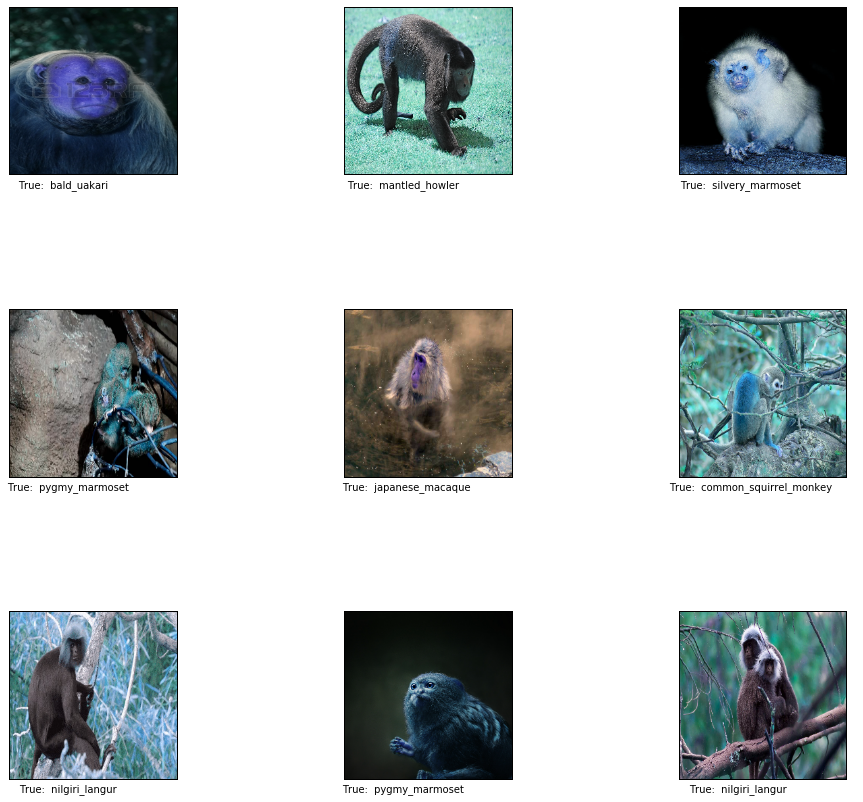

In [9]:
# Get some random images and their labels from the train set.

images, cls_true  = x_train, y_train

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

In [10]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [11]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [12]:
def new_conv_layer(input,              
                   num_input_channels, 
                   filter_size,        
                   num_filters,        
                   use_pooling=True):  

    shape = [filter_size, filter_size, num_input_channels, num_filters]

    weights = new_weights(shape=shape)

    biases = new_biases(length=num_filters)

    # strides are set to 1 in all dimensions.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    layer += biases

    if use_pooling:
        # 2x2 max-pooling
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    layer = tf.nn.relu(layer)

    return layer, weights

In [13]:
def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat, num_features

In [14]:
def new_fc_layer(input,          
                 num_inputs,     
                 num_outputs,    
                 use_relu=True): 

    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)
    layer = tf.matmul(input, weights) + biases

    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

# Tensorflow implementation

We are using tensorflow to construct this model    
In a nutshell the graph computes various mathemetical operations by defining the functions and corresponding variables befor hand and inputting the data with placeholder variables. Then we also define varaibles that will be used to optimize the model, In this case our one-hot encoded labels.

In [15]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

The connvolutional step takes in an images and constructs filters which will be used to identify monkey features. A 2X2 maxpooling is used to down sample the image to identify macro features.    
This is one of the key steps which make or break the problem, A small filter will help us to identify micro features but then again larger filter will help us to identenfy larger features. Its depends on the dataset to identify right size of the filter to identify the features which matters with out loosing data.    
At the end we connect a fully connected layer to identify the many to many relationship betwee these macro features which will help us to classify the monkeys correctly.

In [16]:
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)
layer_conv3, weights_conv3 = \
    new_conv_layer(input=layer_conv2,
                   num_input_channels=num_filters2,
                   filter_size=filter_size3,
                   num_filters=num_filters3,
                   use_pooling=True)
    
layer_flat, num_features = flatten_layer(layer_conv3)

layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=fc_size,
                         use_relu=True)
layer_fc3 = new_fc_layer(input=layer_fc2,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)


The final Fully connected layer fires up our 10 label neurons, as we are using RELU we need to use softmax to get the probability of these 10 labels to work with the optimizer. The neuron with highes probability is selected as our predicted class Cross entropy is used as the cost function Cost function that can be used to guide the optimization of the variables. ADAM optimizer is used to updates the variables.

In [17]:
y_pred = tf.nn.softmax(layer_fc3)
y_pred_cls = tf.argmax(y_pred, dimension=1)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc3,
                                                        labels=y_true)
cost = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

correct_prediction = tf.equal(y_pred_cls, y_true_cls)

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))



# Tensor flow session & Initialization

In [18]:
session = tf.Session()

In [19]:
session.run(tf.global_variables_initializer())

In [20]:
train_batch_size = batch_size

Helper functions to print progress and select a random batch for calculations so that we dont exhaust the memory.

In [21]:
def print_progress(epoch, feed_dict_train, feed_dict_validate, val_loss):
    acc = session.run(accuracy, feed_dict=feed_dict_train)
    val_acc = session.run(accuracy, feed_dict=feed_dict_validate)
    msg = "Epoch {0} --- Training Accuracy: {1:>6.1%}, Validation Loss: {3:.3f}"
    print(msg.format(epoch + 1, acc, val_acc, val_loss))
    
def random_batch(x_train, y_train):
    num_images = len(x_train)
    idx = np.random.choice(num_images,
                           size=train_batch_size,
                           replace=False)
    x_batch = x_train[idx, :, :, :]
    y_batch = labels_train[idx, :]

    return x_batch, y_batch

# Optimization Step

In [22]:
total_iterations = 0

def optimize(num_iterations):
    global total_iterations
    start_time = time.time()
    
    best_val_loss = float("inf")
    patience = 0

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # random batch of training validation samples.
        x_batch, y_true_batch = random_batch(x_train, labels_train)
        x_valid_batch, y_valid_batch =random_batch( x_val, labels_val)

        # reshaping the 4D array to 1D array

        x_batch = x_batch.reshape(train_batch_size, img_size_flat)
        x_valid_batch = x_valid_batch.reshape(train_batch_size, img_size_flat)

        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}
        
        feed_dict_validate = {x: x_valid_batch,
                              y_true: y_valid_batch}

        # Optimizer using the random batch
        session.run(optimizer, feed_dict=feed_dict_train)
        

        # Print status at end of each epoch.
        if i % int(len(x_train)/batch_size) == 0: 
            val_loss = session.run(cost, feed_dict=feed_dict_validate)
            epoch = int(i / int(len(x_train)/batch_size))
            
            print_progress(epoch, feed_dict_train, feed_dict_validate, val_loss)
            
            if early_stopping:    
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience = 0
                else:
                    patience += 1

                if patience == early_stopping:
                    break

    total_iterations += num_iterations

    end_time = time.time()

    time_dif = end_time - start_time

    print("Time elapsed: " + str(timedelta(seconds=int(round(time_dif)))))

# Visualizing the results

In [23]:
def plot_example_errors(cls_pred, correct):
    incorrect = (correct == False)
    # incorrectly classified.
    images = x_val[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = y_val[incorrect]
    
    random_indices = random.sample(range(len(images)), min(len(images), 9))
    plot_images(images=images[random_indices],
                cls_true=cls_true[random_indices],
                cls_pred=cls_pred[random_indices])
    
    
def plot_confusion_matrix(cls_pred):
    cls_true = y_val
    
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)
    print(cm)
    plt.matshow(cm)
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [24]:
def print_validation_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    num_test = len(x_val)
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    i = 0

    while i < num_test:
        j = min(i + batch_size, num_test)

        images = x_val[i:j, :, :, :].reshape(batch_size, img_size_flat)
        
        labels = labels_val[i:j, :]

        feed_dict = {x: images,
                     y_true: labels}

        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        i = j


    cls_true = np.array(y_val)

    correct = (cls_true == cls_pred)

    correct_sum = correct.sum()

    acc = float(correct_sum) / num_test

    
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [25]:
len(x_val)

272

In [26]:
optimize(num_iterations=1000)

Epoch 1 --- Training Accuracy:  12.5%, Validation Loss: 4.626
Epoch 2 --- Training Accuracy:  16.2%, Validation Loss: 2.920
Epoch 3 --- Training Accuracy:  23.5%, Validation Loss: 2.479
Epoch 4 --- Training Accuracy:  34.6%, Validation Loss: 2.346
Epoch 5 --- Training Accuracy:  40.4%, Validation Loss: 2.484
Epoch 6 --- Training Accuracy:  56.6%, Validation Loss: 2.679
Epoch 7 --- Training Accuracy:  47.8%, Validation Loss: 3.040
Epoch 8 --- Training Accuracy:  58.1%, Validation Loss: 3.241
Epoch 9 --- Training Accuracy:  70.6%, Validation Loss: 3.192
Epoch 10 --- Training Accuracy:  74.3%, Validation Loss: 3.926
Epoch 11 --- Training Accuracy:  75.7%, Validation Loss: 3.774
Epoch 12 --- Training Accuracy:  86.0%, Validation Loss: 3.946
Epoch 13 --- Training Accuracy:  85.3%, Validation Loss: 4.088
Epoch 14 --- Training Accuracy:  93.4%, Validation Loss: 4.887
Epoch 15 --- Training Accuracy:  93.4%, Validation Loss: 4.696
Epoch 16 --- Training Accuracy:  92.6%, Validation Loss: 5.246
E

In [27]:
print_validation_accuracy()

Accuracy on Test-Set: 67.3% (183 / 272)


# Validation accuracy and confusion matrix

Accuracy on Test-Set: 67.3% (183 / 272)
Example errors:


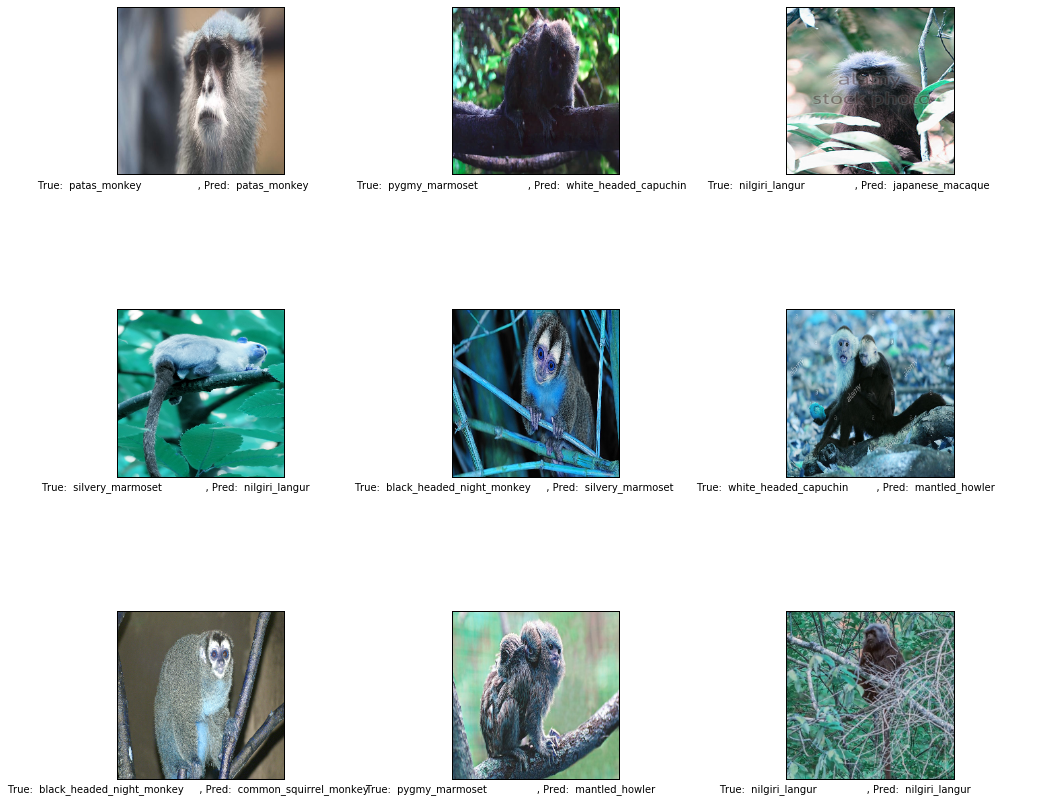

Confusion Matrix:
[[17  0  0  0  0  2  0  1  1  5]
 [ 0 16  2  1  0  2  1  4  2  0]
 [ 0  0 26  1  0  0  0  0  0  0]
 [ 0  2  0 21  0  1  3  1  2  0]
 [ 3  0  2  0 15  0  3  1  0  2]
 [ 4  0  1  1  0 10  5  1  1  5]
 [ 0  0  0  0  0  1 23  1  1  0]
 [ 0  2  0  1  0  2  1 20  2  0]
 [ 0  0  0  1  0  0  1  5 20  0]
 [ 4  2  0  0  1  2  0  2  0 15]]


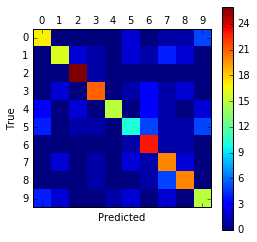

In [28]:
print_validation_accuracy(show_example_errors=True, show_confusion_matrix=True)

In [29]:
def plot_conv_weights(weights, input_channel=0):

    w = session.run(weights)

    w_min = np.min(w)
    w_max = np.max(w)

    num_filters = w.shape[3]

    num_grids = math.ceil(math.sqrt(num_filters))
    
    fig, axes = plt.subplots(num_grids, num_grids, figsize=(10,10))

    for i, ax in enumerate(axes.flat):
        if i<num_filters:

            img = w[:, :, input_channel, i]

            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()
    
def plot_conv_layer(layer, image):
    
    image = image.reshape(img_size_flat)

    feed_dict = {x: [image]}

    values = session.run(layer, feed_dict=feed_dict)

    num_filters = values.shape[3]

    num_grids = math.ceil(math.sqrt(num_filters))

    fig, axes = plt.subplots(num_grids, num_grids,figsize=(10,10))

    for i, ax in enumerate(axes.flat):
        if i<num_filters:

            img = values[0, :, :, i]

            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

In [30]:
def plot_image(image):
    plt.imshow(image.reshape(img_size, img_size, num_channels),
               interpolation='nearest')
    plt.show()

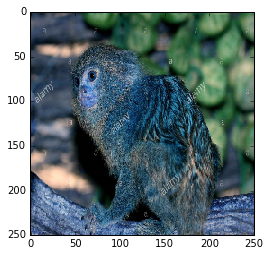

In [31]:
image1 = x_test[0]
plot_image(image1)

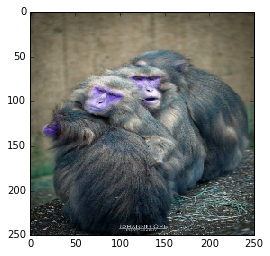

In [32]:
image2 = x_test[34]
plot_image(image2)

# Visualization of Weights and Layers

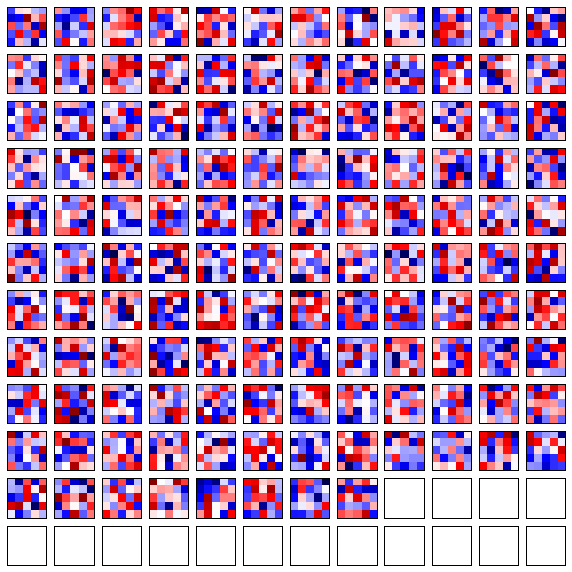

In [33]:
plot_conv_weights(weights=weights_conv1)

The Convolutional weights represent the import features in the image, Blue represents negative weights and RED represents positive weights.

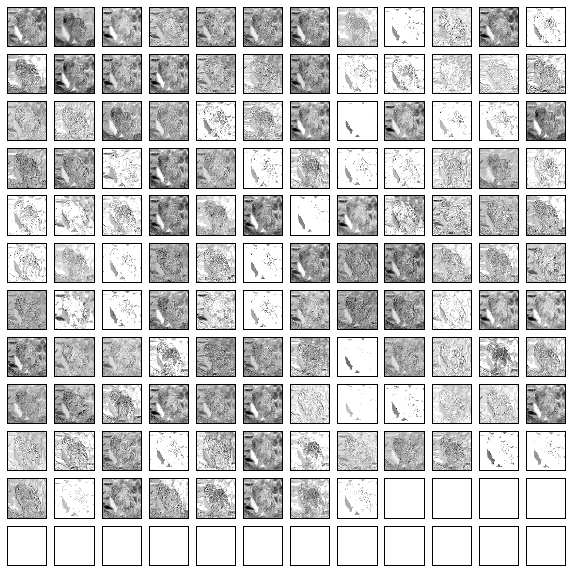

In [34]:
plot_conv_layer(layer=layer_conv1, image=image1)

Applying the Convolutional weight on the image gives us the above output, we can observe that weight try to identify diferent set of features pretaining to the monkey classes and to identify the monkey object overall. These images are then fed in to the second layer for similiar feature extraction process. But this time the layer down sample's the images to extract more important feature which will help classify the images whith much less computational work.

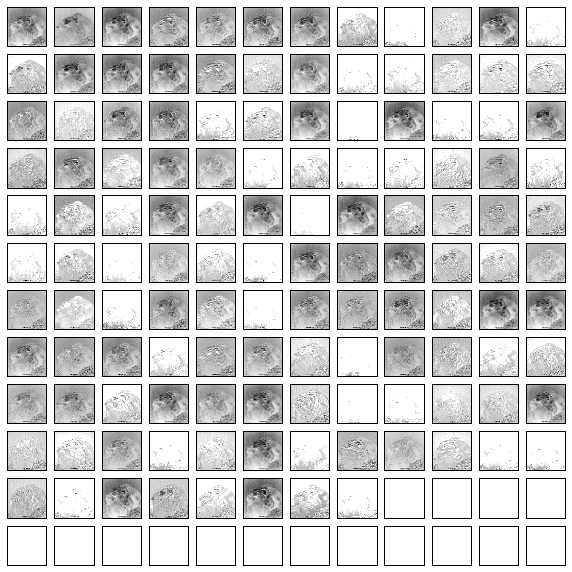

In [35]:
plot_conv_layer(layer=layer_conv1, image=image2)

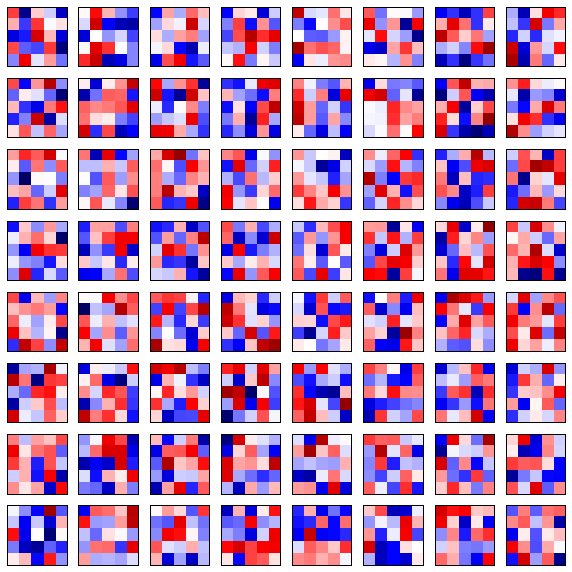

In [36]:
plot_conv_weights(weights=weights_conv2, input_channel=0)

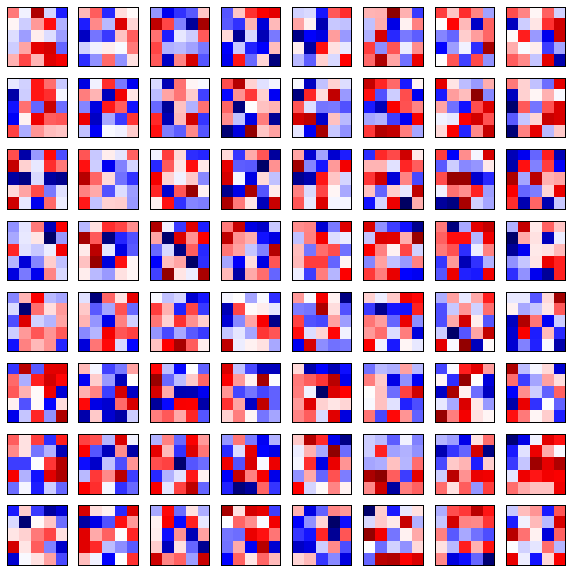

In [37]:
plot_conv_weights(weights=weights_conv2, input_channel=1)

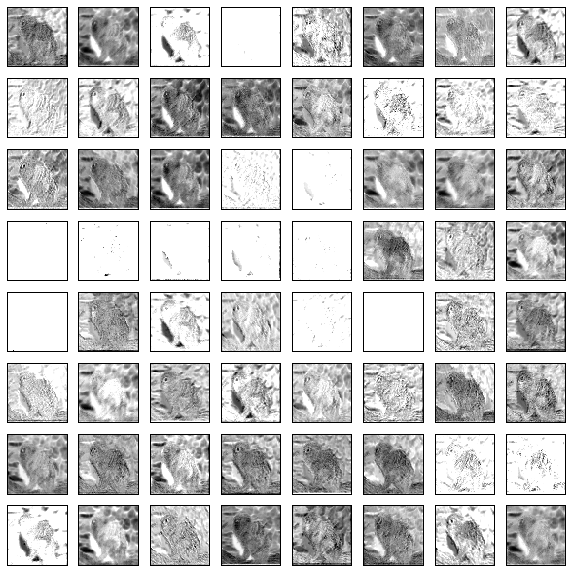

In [38]:
plot_conv_layer(layer=layer_conv2, image=image1)

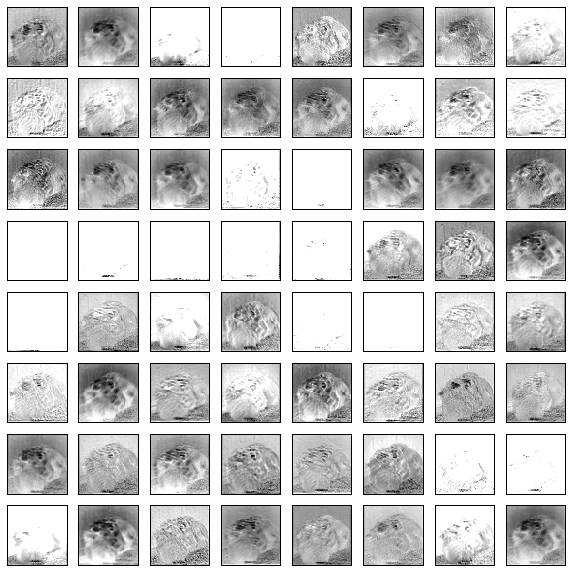

In [39]:
plot_conv_layer(layer=layer_conv2, image=image2)

In [46]:
def plot_example_errors1(cls_pred, correct):
    incorrect = (correct == False)
    # incorrectly classified.
    images = x_test[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = y_test[incorrect]
    
    random_indices = random.sample(range(len(images)), min(len(images), 9))
    plot_images(images=images[random_indices],
                cls_true=cls_true[random_indices],
                cls_pred=cls_pred[random_indices])

In [47]:
batch_size1=110
def print_test_accuracy(show_example_errors=False):

    num_test = len(x_test)

    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    i = 0

    while i < num_test:
        j = min(i + batch_size1, num_test)
        
        images = x_test[i:j, :, :, :].reshape(batch_size1, img_size_flat)
        
        labels = labels_test[i:j, :]

        feed_dict = {x: images,
                     y_true: labels}

        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        i = j

    cls_true = np.array(y_test)

    correct = (cls_true == cls_pred)

    correct_sum = correct.sum()

    acc = float(correct_sum) / num_test


    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))
    
    cls_true = y_test
    

    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    print(cm)

    plt.matshow(cm)

    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.show()
    
    if show_example_errors:
        print("Example errors:")
        plot_example_errors1(cls_pred=cls_pred, correct=correct)

# Test accuracy and confusion matrix

Accuracy on Test-Set: 68.2% (75 / 110)
[[6 1 0 0 0 1 0 0 1 1]
 [0 8 0 0 1 0 0 2 0 0]
 [0 0 8 2 0 1 0 0 0 0]
 [0 0 0 7 0 0 4 1 0 0]
 [0 0 0 0 8 0 0 3 0 0]
 [1 0 0 0 0 9 0 1 0 0]
 [0 0 0 1 0 0 7 2 1 0]
 [0 1 1 0 0 0 0 9 0 0]
 [0 0 0 1 2 1 0 1 6 0]
 [1 0 0 0 0 1 0 1 1 7]]


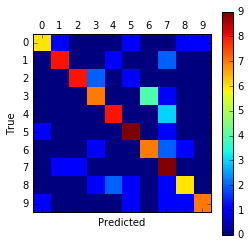

Example errors:


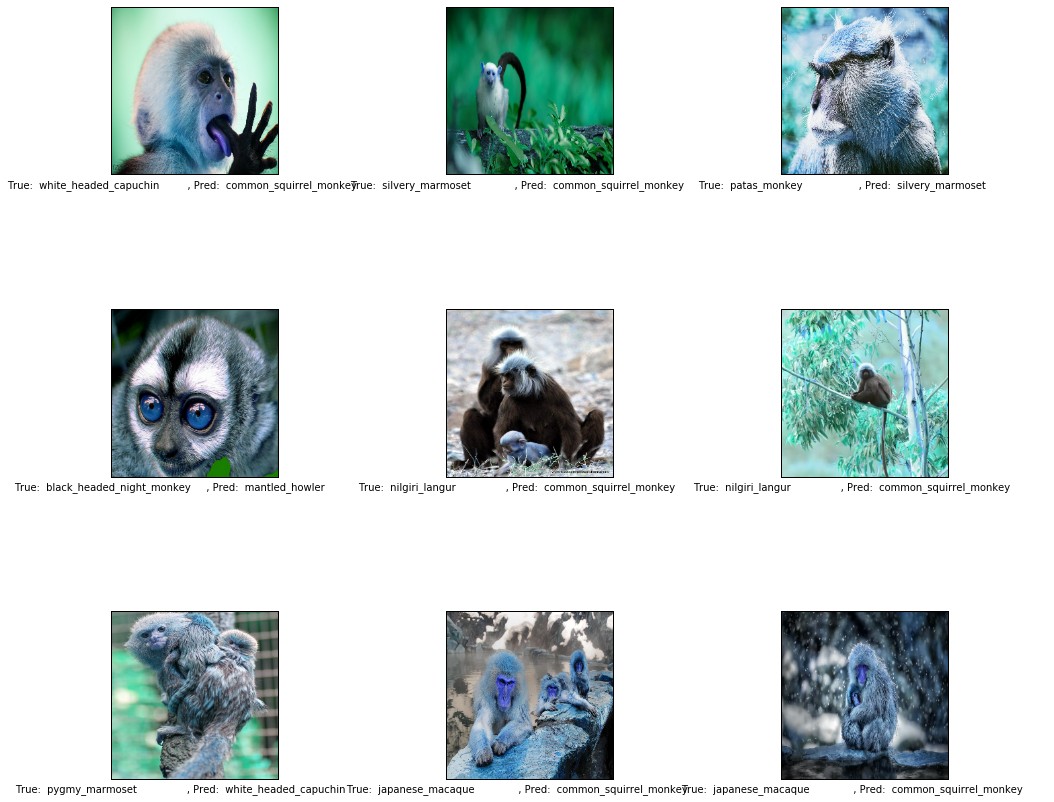

In [48]:
print_test_accuracy(show_example_errors=True)

# Conclusion

The Accuracy of 68% on a multi-class classification problem with 10 classes is good enough. But CNN's are well know for image classification at a level exceeding humans. So there is still room for improvement. Lets interpret the results and find whats going wrong with the classifications.     
Although the miss-classification's are distributed on all classes, We can observe a pattern on class 3 and class 4. These two classes are miss-classified on mostly on class 6 and 7. This is an interesting pattern, lets plot some images from these two classes to understan the reason.

0     mantled_howler                
1     patas_monkey                  
2     bald_uakari                   
3     japanese_macaque              
4     pygmy_marmoset                
5     white_headed_capuchin         
6     silvery_marmoset              
7     common_squirrel_monkey        
8     black_headed_night_monkey     
9     nilgiri_langur                
Name: Common Name, dtype: object
japanese_macaque
silvery_marmoset
pygmy_marmoset
common_squirrel_monkey


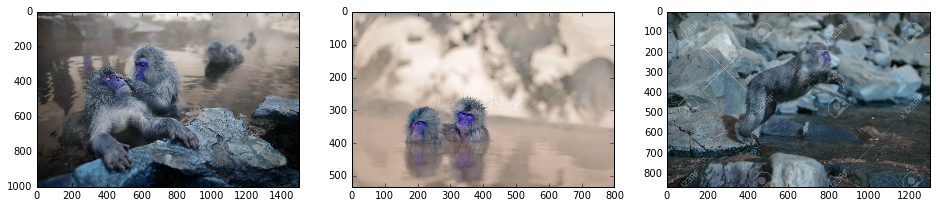

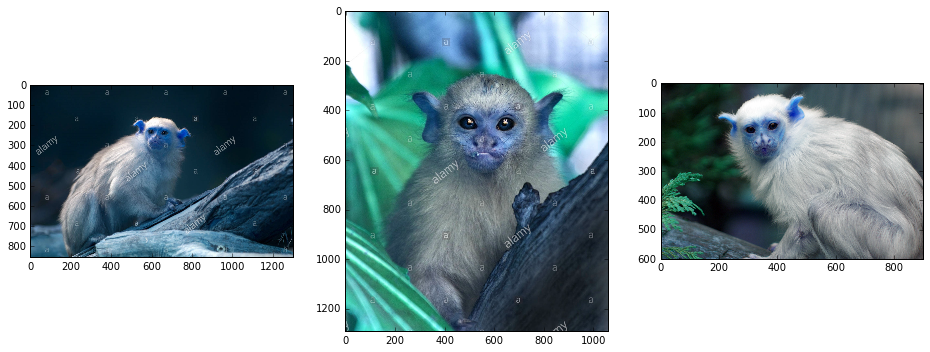

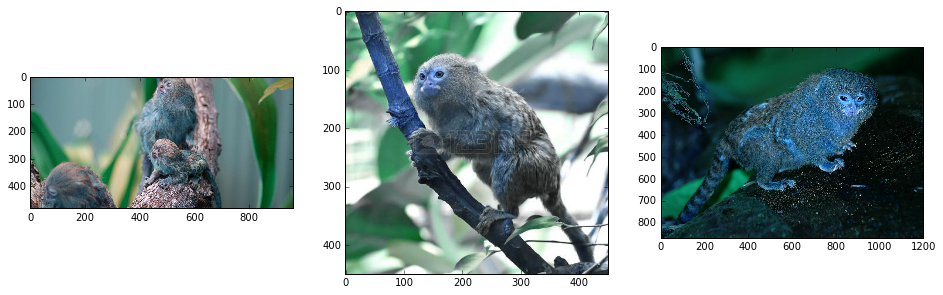

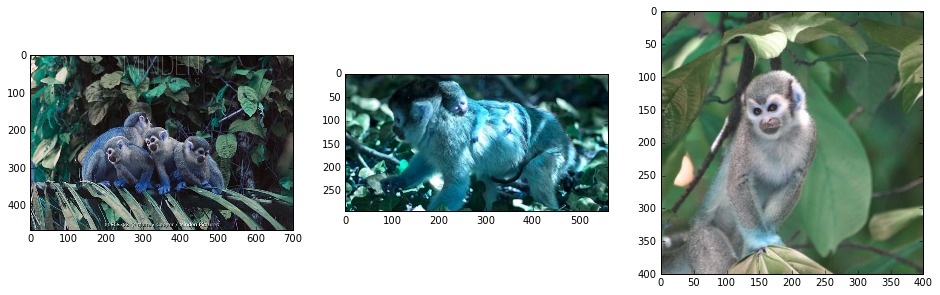

In [49]:
print(labels)
multipleImages = glob('./10-monkey-species/training/n3/**')
def plotThreeImages(images):
    r = random.sample(images, 3)
    plt.figure(figsize=(16,16))
    plt.subplot(131)
    plt.imshow(cv2.imread(r[0]))
    plt.subplot(132)
    plt.imshow(cv2.imread(r[1]))
    plt.subplot(133)
    plt.imshow(cv2.imread(r[2])); 
plotThreeImages(multipleImages)
print("japanese_macaque")
multipleImages = glob('./10-monkey-species/training/n6/**')
plotThreeImages(multipleImages)
print("silvery_marmoset")
multipleImages = glob('./10-monkey-species/training/n4/**')
plotThreeImages(multipleImages)
print("pygmy_marmoset")
multipleImages = glob('./10-monkey-species/training/n7/**')
plotThreeImages(multipleImages)
print("common_squirrel_monkey")

The first row and second row images belong to class3(japanese_macaque) and class6 (silvery_marmoset). Looking at these image we can deduce some of the common feature like Long coat, white fur and similare face structure. This could be a reason for the miss classification on class3. Similarly the third row and fourth row images belong to class4(pygmy_marmoset) and class7(common_squirrel_monkey). These two classes also has some similar features like the color of the fur, short coat and distinctive scowl face. So how to improve the classification accuracy?

# Future work

I plan to tweak and continue building the model with more layers to find the best architectures to classify these images. And then next step would be to build an Ensemble model including these NN architectures and take voting to gain better performance.